﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿[배경] 
안녕하세요, 여러분 :) 월간 데이콘 파일럿 : 결측치 보간 챌린지에 오신 것을 진심으로 환영합니다.



이번 챌린지는 데이터 분석에서 중요한 한 단계인 결측치 보간에 초점을 맞춥니다.

가상 시나리오로 일정한 간격으로 센서가 온도를 측정한 단변량 시계열 데이터를 다루게 됩니다. 이 데이터는 기기 오류나 통신 문제로 결측치가 포함된 상태입니다.



참가자 여러분은 이러한 결측치를 실제 값과 최대한 가깝게 보간하는 방법을 연습하고, 이를 실제와 유사한 상황에 적용하는 경험을 할 수 있습니다. 이 과정은 데이터 전처리의 핵심이며, 분석 결과의 질을 크게 좌우합니다. 따라서, 다양한 상황에 맞는 최적의 보간 전략을 세우는 능력을 개발하는 것이 중요합니다.



이 챌린지는 경쟁보다는 학습과 건강한 교류를 중시하여, 모든 참가자가 자유롭게 의견을 나누고, 함께 성장할 수 있는 환경을 제공합니다. 특히, 이번 대회는 데이콘 AI 경진대회 참여에 어려움을 겪었거나 부담을 느꼈던 분들도 부담 없이 참여할 수 있도록 기획되었습니다.



데이커 여러분 모두가 결측치 보간에 대한 이해를 깊이 있게 하고, 데이콘 커뮤니티 내에서 활발한 토론의 장이 펼쳐지길 바라며, 이 챌린지가 여러분의 데이터 과학 여정에 의미 있는 발걸음이 되기를 기대합니다. 



[주제]
단변량 시계열 데이터의 결측치 보간



[설명]
단변량 시계열 데이터에 존재하는 결측치를 최대한 실제값과 유사하도록 보간

🎈 data.csv [파일]
[시나리오] SAMPLE_00000 ~ SAMPLE_62628은 일정한 텀 마다 센서에서 온도를 측정한 데이터이며, 이 과정에서 기기/통신 결함으로 인한 결측이 발생
id : 샘플 고유 ID
Value : 일정한 텀 마다 센서에서 측정된 온도 값 (°C)

🎈 sample_submission.csv [파일] - 제출 양식
id : 샘플 고유 ID
Value : 결측치를 모두 보간한 온도 값 (°C)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./data.csv')

In [3]:
df.head(2)

,id,Value
0,SAMPLE_00000,27.636770
1,SAMPLE_00001,27.250818


In [4]:
print(len(df['Value'])) # 전체 행 길이

62629


In [5]:
print(df.isnull().sum()) # 결측치 개수

id           0
Value    22493
dtype: int64


In [6]:
print(df['Value'].min())
print(df['Value'].max())

6.886154652
37.697052


# 결측치 분포 확인

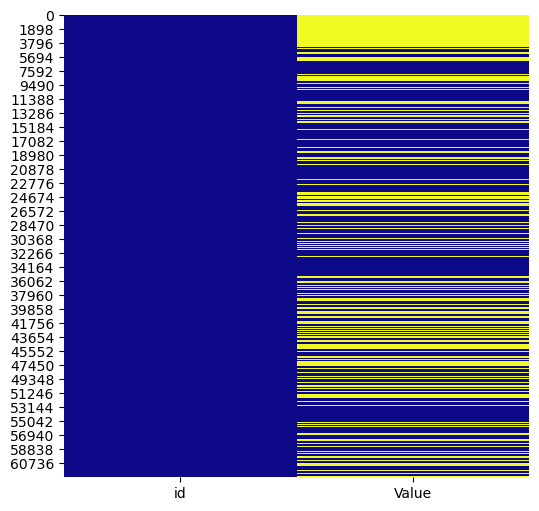

In [7]:
plt.figure(figsize=(6, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='plasma')
plt.show()

- 연속적으로 결측치가 있으므로 이를 고려하여 보간법을 선택해야 합니다.

# 시계열 데이터가 선형인지 아닌지 확인
- 데이터가 선형인지 아닌지를 확인하고자 합니다. 이에 따라 보간 방법이 달라질 수 있기 때문입니다.

## 🧶 결정 계수 이용

선형성 확인:


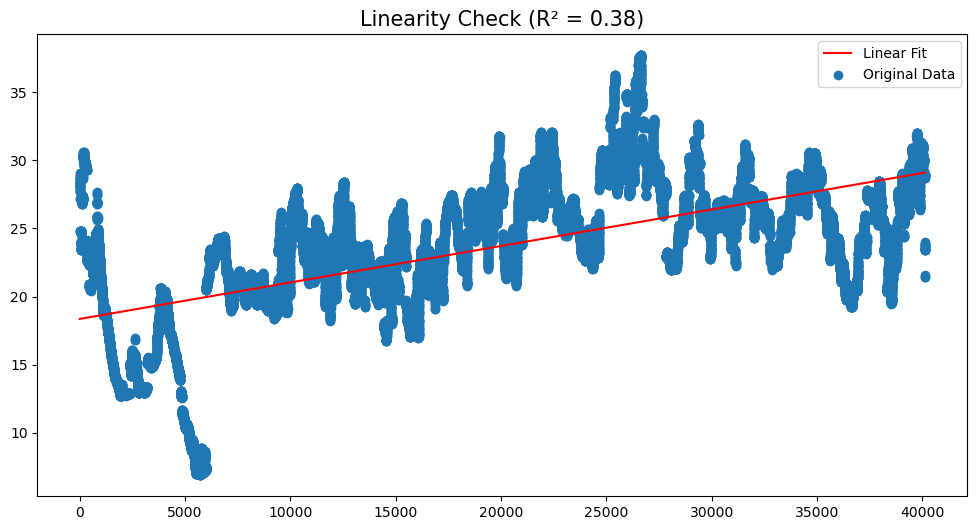

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def check_linearity(series):
    not_na_series = series.dropna().reset_index(drop=True)
    x = np.arange(len(not_na_series)).reshape(-1, 1)
    y = not_na_series.values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, label='Original Data')
    plt.plot(x, y_pred, color='red', label='Linear Fit')
    plt.title(f'Linearity Check (R² = {r2:.2f})', fontsize = 15)
    plt.legend()
    plt.show()
    
    return r2

print("선형성 확인:")
r2 = check_linearity(df['Value'])

In [9]:
# 임계값 설정 # 결정 계수는 0.38인 상태
threshold = 0.7 # 일반적으로 0.7에서 0.9 사이

if r2 > threshold:
    print("선형적인 데이터이므로 선형 보간법을 선택하자")
else:
    print("비선형적인 데이터이므로 비선형 보간법을 선택하자")

비선형적인 데이터이므로 비선형 보간법을 선택하자


## 🧶 잔차 분석

In [10]:
# id 컬럼에서 숫자 추출
df['id_numeric'] = df['id'].str.extract('(\d+)').astype(int)

train_data = df.dropna()
X = train_data['id_numeric'].values.reshape(-1, 1)
y = train_data['Value'].values
model = LinearRegression()
model.fit(X, y)

# 예측 및 잔차 계산
predictions = model.predict(X)
residuals = y - predictions

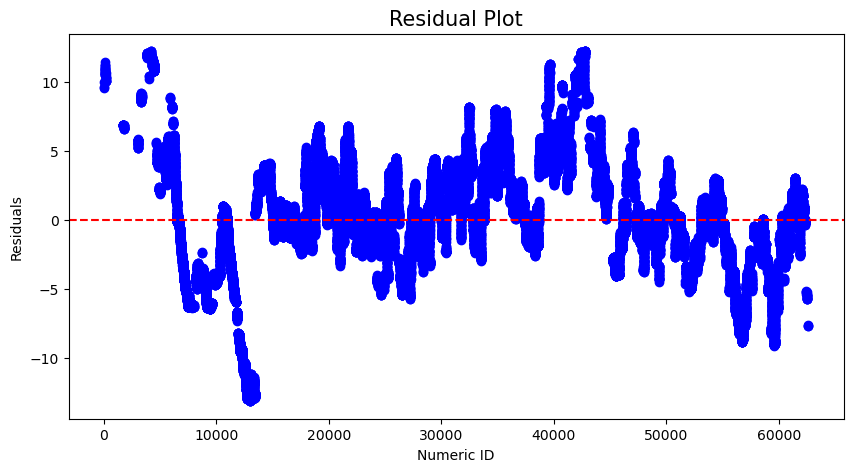

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(X, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot', fontsize=15)
plt.xlabel('Numeric ID')
plt.ylabel('Residuals')
plt.show()

- 잔차 플롯의 형태로 보아 비선형 관계일 가능성이 있습니다.

In [12]:
# 잔차의 기술 통계
print("Residual Summary:")
pd.Series(residuals).describe() # 이상치들이 눈에 띈다

Residual Summary:


count    4.013600e+04
mean     1.994108e-15
std      4.029250e+00
min     -1.313892e+01
25%     -2.038544e+00
50%      1.293761e-01
75%      2.705507e+00
max      1.221404e+01
dtype: float64

- 여기까지 결론 : 비선형 관계임을 고려해서 모델을 선정해야 합니다.

# 결측치를 처리하는 여러가지 방법

## 🎯 평균 또는 중앙값 대체
- 이 방법은 간단한 반면에 이상치에 민감하다는 특징이 있습니다.

In [13]:
df['Value'].describe() # mean과 중앙값(50%) 확인

count    40136.000000
mean        23.725770
std          5.055014
min          6.886155
25%         21.080368
50%         24.260941
75%         27.057861
max         37.697052
Name: Value, dtype: float64

## 🎯 최빈값 대체
- 이 방법은 해당 범주에서 가장 많이 등장하는 값으로 대체하는 방법입니다.

In [14]:
mode_value = df['Value'].mode().iloc[0]

mode_count = df['Value'].value_counts()[mode_value] # 빈도 수

# 결과 출력
print('최빈값:', mode_value)
print('최빈값 count:', mode_count)

최빈값: 27.15434837
최빈값 count: 505


## 🎯 선형 보간법
- 이 방법은 결측치 양쪽의 값을 기반으로 선형적으로 값을 추정합니다. 비선형 관계에 해당하는 이 데이터에는 다소 적합하지 않을 수 있는 방법입니다.

In [15]:
from scipy import interpolate # scipy 라이브러리 사용

df['Value_linear'] = df['Value'].interpolate(method='linear') # method에 다양한 방법 넣기

In [16]:
df

,id,Value,id_numeric,Value_linear
0,SAMPLE_00000,27.636770,0,27.636770
1,SAMPLE_00001,27.250818,1,27.250818
2,SAMPLE_00002,27.154348,2,27.154348
3,SAMPLE_00003,NaN,3,27.165513
4,SAMPLE_00004,NaN,4,27.176678
...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711
62625,SAMPLE_62625,NaN,62625,21.485741
62626,SAMPLE_62626,21.465771,62626,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141


## 🎯 스플라인 보간법
- 이 방법은 결측치를 채우기 위해 고차 다항식을 사용합니다.

In [17]:
df['Value_spline'] = df['Value'].interpolate(method='spline', order=3)

In [18]:
df

,id,Value,id_numeric,Value_linear,Value_spline
0,SAMPLE_00000,27.636770,0,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265
4,SAMPLE_00004,NaN,4,27.176678,28.661837
...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141


## 🎯 이차 보간법
- 이 방법은 보간하려는 지점 근처의 세 개의 데이터 포인트를 사용하여 이차 다항식을 만들어 피팅시킵니다. 하지만 이 데이터셋에서는 결측치가 연속적으로 발생한 경우가 있기 때문에 적용이 어려울 수 있습니다. 이차 보간법은 세 개의 데이터 포인트를 사용하는 방법이기 때문입니다.

In [19]:
df['Value_quad'] = df['Value'].interpolate(method='quadratic', order=3)

In [20]:
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993
...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141


## 🎯 큐빅 보간법
- 이 방법은 보간하려는 지점 근처의 데이터 포인트들을 사용하여 3차 다항식을 피팅시킵니다. 따라서 결측치가 연속적으로 발생한 이 데이터의 경우 이웃한 데이터 포인트들을 사용하여 보간을 수행하기 어려울 수 있습니다.  
- 이때는 결측치를 둘러싼 비결측치 데이터 포인트를 사용하여 cubic 보간법을 적용한 후, 결측치 부분을 여러 개의 작은 구간으로 나누어 각 구간에 대해 cubic 보간법을 적용할 수 있습니다.

In [21]:
df['Value_cubic'] = df['Value'].interpolate(method='quadratic', order=3)
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad,Value_cubic
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404,27.101404
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993,27.050993
...,...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178,21.231178
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040,21.346040
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141,21.562141


## 🎯 큐빅 스플라인 보간법
- 큐빅 보간법은 결측치가 연속적으로 발생한 데이터의 경우, 이웃한 데이터 포인트들을 사용하여 보간을 수행하기 어려울 수 있습니다.
- 이때는 결측치를 둘러싼 비결측치 데이터 포인트를 사용하여 cubic 보간법을 적용한 후, 결측치 부분을 여러 개의 작은 구간으로 나누어 각 구간에 대해 cubic 보간법을 적용할 수 있습니다.

In [22]:
from scipy.interpolate import CubicSpline # 직접 구간을 나누기 위해서는 CubicSpline 필요함

df['Value_cubic5'] = df['Value'] # 작은 구간 크기 컬럼에 반영

In [23]:
not_na_indices = df.index[~df['Value'].isna()]
not_na_values = df['Value'].dropna()

In [24]:
cs = CubicSpline(not_na_indices, not_na_values)

na_indices = df.index[df['Value'].isna()]

In [25]:
# 결측치 구간을 작은 구간으로 나누기
def get_sub_intervals(indices, interval_size):
    sub_intervals = []
    current_interval = [indices[0]]

    for i in range(1, len(indices)):
        if indices[i] == indices[i - 1] + 1 and len(current_interval) < interval_size:
            current_interval.append(indices[i])
        else:
            sub_intervals.append(current_interval)
            current_interval = [indices[i]]

    if current_interval:
        sub_intervals.append(current_interval)

    return sub_intervals

In [26]:
interval_size = 5

na_sub_intervals = get_sub_intervals(na_indices, interval_size)

# 각 작은 구간에 대해 보간 적용
for interval in na_sub_intervals:
    interpolated_values = cs(interval)
    df.loc[interval, 'Value_cubic5'] = interpolated_values

In [27]:
df['Value_cubic5'].fillna(df['Value'], inplace=True)

In [28]:
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad,Value_cubic,Value_cubic5
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404,27.101404,27.109326
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993,27.050993,27.068088
...,...,...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178,21.231178,21.228087
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040,21.346040,21.343341
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141,21.562141,21.562141


## 🎯 K-최근접 이웃(KNN) 보간법
- 이 방법은 KNN 알고리즘을 사용하여 결측치 주변의 비슷한 데이터 포인트들의 값을 기반으로 결측치를 추정합니다. 
- 하지만 연속적인 결측치가 많이 존재하는 이 데이터에는 적합하지 않을 수 있습니다.

## 🎯 ARIMA 
- ARIMA는 시계열 데이터를 보간하는 데 많이 사용됩니다. 
- 시계열 데이터의 자기상관성을 기반으로 예측합니다.

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# 인덱스를 숫자형으로 설정
df['id_num'] = df['id'].apply(lambda x: int(x.split('_')[1]))
df.set_index('id_num', inplace=True)

# 결측치가 아닌 데이터만 사용하여 모델 학습
train_df = df.dropna()

# ARIMA 모델 학습
model = ARIMA(train_df['Value'], order=(2, 1, 0))  # p, d, q 파라미터는 데이터에 맞게 조정
fitted_model = model.fit()

# 예측 수행
df['Value_arima'] = np.nan  # Value_arima 컬럼 생성

# 예측 구간을 명확히 지정
start = train_df.index.min()
end = df.index.max()
predictions = fitted_model.predict(start=start, end=end, typ='levels')

# 예측 값을 데이터프레임에 반영
df.loc[start:end, 'Value_arima'] = predictions

# 결측치를 예측 값으로 대체
df['Value_arima'] = df['Value'].combine_first(df['Value_arima'])

# id 컬럼을 복원하여 최종 데이터프레임 생성
df.reset_index(inplace=True)
df.rename(columns={'index': 'id_num'}, inplace=True)
df['id'] = df['id_num'].apply(lambda x: f'SAMPLE_{x:05d}')

C:\Users\Dayeon Lee\anaconda3\envs\dayeon\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dayeon Lee\anaconda3\envs\dayeon\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dayeon Lee\anaconda3\envs\dayeon\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dayeon Lee\anaconda3\envs\dayeon\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [4]:
df

,id_num,id,Value,Value_arima
0,0,SAMPLE_00000,27.636770,27.636770
1,1,SAMPLE_00001,27.250818,27.250818
2,2,SAMPLE_00002,27.154348,27.154348
3,3,SAMPLE_00003,NaN,27.144286
4,4,SAMPLE_00004,NaN,28.483798
...,...,...,...,...
62624,62624,SAMPLE_62624,NaN,21.467120
62625,62625,SAMPLE_62625,NaN,21.467120
62626,62626,SAMPLE_62626,21.465771,21.465771
62627,62627,SAMPLE_62627,21.562141,21.562141


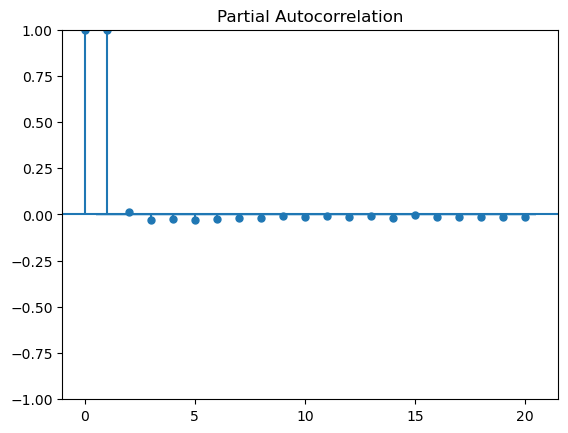

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf

# PACF 플롯 생성
plot_pacf(df['Value'].dropna(), lags=20)
plt.show() # p는 2로 해야 한다(세번째부터 값이 떨어지는 것 확인)

## 🎯 랜덤 포레스트
- 랜덤 포레스트 또한 결측치 보간에 사용될 수 있습니다. 비선형 관계일 때 좋은 성능을 보일 수 있습니다.
- RandomForestRegressor에 n_estimators, max_depth, min_samples_split, min_samples_leaf 등의 파라미터를 조정하여 예측 성능을 더 향상시킬 수 있습니다

In [32]:
from sklearn.ensemble import RandomForestRegressor

df_no_missing = df[df['Value'].notna()]
X_train = df_no_missing.index.values.reshape(-1, 1)  # id를 인덱스로 사용
y_train = df_no_missing['Value']

model = RandomForestRegressor(n_estimators=100, random_state=42) # 이 부분 조정 가능. 100은 초기값으로 많이 사용.
model.fit(X_train, y_train) # 하이퍼파라미터를 조정했지만 이 세팅에서 가장 성능 높음.

df['Value_rf'] = df['Value']
missing_indices = df[df['Value'].isna()].index
for index in missing_indices:
    pred_value = model.predict(np.array(index).reshape(1, -1))
    df.loc[index, 'Value_rf'] = pred_value

In [33]:
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad,Value_cubic,Value_cubic5,Value_arima,Value_rf
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404,27.101404,27.109326,27.144286,27.272062
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993,27.050993,27.068088,28.483798,27.272062
...,...,...,...,...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178,21.231178,21.228087,21.467120,21.573713
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040,21.346040,21.343341,21.467120,21.573713
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141


## 🎯 LightGBM
- 학습 속도도 빠르고 랜덤 포레스트와 유사하지만 이 데이터에서는 성능이 좋지 않았습니다.

In [34]:
import lightgbm as lgb

df_no_missing = df[df['Value'].notna()]
X_train = df_no_missing.index.values.reshape(-1, 1)
y_train = df_no_missing['Value']

train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42
}

model = lgb.train(params, train_data, num_boost_round=100)

df['Value_lgbm'] = df['Value']
missing_indices = df[df['Value'].isna()].index
for index in missing_indices:
    pred_value = model.predict(np.array(index).reshape(1, -1))
    df.loc[index, 'Value_lgbm'] = pred_value

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 40136, number of used features: 1
[LightGBM] [Info] Start training from score 23.725770


In [35]:
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad,Value_cubic,Value_cubic5,Value_arima,Value_rf,Value_lgbm
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404,27.101404,27.109326,27.144286,27.272062,26.650056
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993,27.050993,27.068088,28.483798,27.272062,26.650056
...,...,...,...,...,...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178,21.231178,21.228087,21.467120,21.573713,29.354561
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040,21.346040,21.343341,21.467120,21.573713,29.354561
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141


## 🎯 XG boost
- 학습 속도가 빠르고 이 데이터에 대해서도 좋은 성능을 보였습니다.
- 비선형 관계에 적합한 모델입니다. 

In [36]:
from xgboost import XGBRegressor

df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# 시계열 데이터를 위한 feature 생성
df['Time'] = np.arange(len(df))

train_df = df.dropna(subset=['Value'])
X_train = train_df[['Time']]
y_train = train_df['Value']

test_df = df[df['Value'].isna()]
X_test = test_df[['Time']]

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

df.loc[df['Value'].isna(), 'Value_xgb'] = xgb_model.predict(X_test)

df['Value_xgb'] = df.apply(lambda row: row['Value'] if not np.isnan(row['Value']) else row['Value_xgb'], axis=1)

df.drop(columns=['Time'], inplace=True)

In [37]:
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad,Value_cubic,Value_cubic5,Value_arima,Value_rf,Value_lgbm,Value_xgb
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404,27.101404,27.109326,27.144286,27.272062,26.650056,27.337168
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993,27.050993,27.068088,28.483798,27.272062,26.650056,27.337168
...,...,...,...,...,...,...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178,21.231178,21.228087,21.467120,21.573713,29.354561,21.703209
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040,21.346040,21.343341,21.467120,21.573713,29.354561,21.703209
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141


# 🎯 랜덤 포레스트 + xgboost 앙상블

In [38]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

df_no_missing = df[df['Value'].notna()]
X_train = df_no_missing.index.values.reshape(-1, 1) 
y_train = df_no_missing['Value']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 100,
    'random_state': 42
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

df['Value_ensemble'] = df['Value']
missing_indices = df[df['Value'].isna()].index

for index in missing_indices:
    rf_pred = rf_model.predict(np.array(index).reshape(1, -1))
    xgb_pred = xgb_model.predict(xgb.DMatrix(np.array(index).reshape(1, -1)))
    # 두 모델의 예측 값을 평균하여 결측치를 대체
    pred_value = (rf_pred + xgb_pred) / 2
    df.loc[index, 'Value_ensemble'] = pred_value

[10:03:45] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [39]:
df

,id,Value,id_numeric,Value_linear,Value_spline,Value_quad,Value_cubic,Value_cubic5,Value_arima,Value_rf,Value_lgbm,Value_xgb,Value_ensemble
0,SAMPLE_00000,27.636770,0,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770,27.636770
1,SAMPLE_00001,27.250818,1,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818,27.250818
2,SAMPLE_00002,27.154348,2,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348,27.154348
3,SAMPLE_00003,NaN,3,27.165513,28.665265,27.101404,27.101404,27.109326,27.144286,27.272062,26.650056,27.337168,27.298819
4,SAMPLE_00004,NaN,4,27.176678,28.661837,27.050993,27.050993,27.068088,28.483798,27.272062,26.650056,27.337168,27.298819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62624,SAMPLE_62624,NaN,62624,21.505711,18.167241,21.231178,21.231178,21.228087,21.467120,21.573713,29.354561,21.703209,22.521051
62625,SAMPLE_62625,NaN,62625,21.485741,18.100353,21.346040,21.346040,21.343341,21.467120,21.573713,29.354561,21.703209,22.521051
62626,SAMPLE_62626,21.465771,62626,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771,21.465771
62627,SAMPLE_62627,21.562141,62627,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141,21.562141


# 제출 파일 만들기

In [40]:
submi = pd.read_csv("./sample_submission.csv")
submi.head()

,id,Value
0,SAMPLE_00000,27.636770
1,SAMPLE_00001,27.250818
2,SAMPLE_00002,27.154348
3,SAMPLE_00003,0.000000
4,SAMPLE_00004,0.000000


In [41]:
submi['Value'] = df['Value_ensemble']
submi.head()

,id,Value
0,SAMPLE_00000,27.636770
1,SAMPLE_00001,27.250818
2,SAMPLE_00002,27.154348
3,SAMPLE_00003,27.298819
4,SAMPLE_00004,27.298819


In [42]:
submi.to_csv("submission.csv", encoding='utf-8', index=False)

- 지금까지 랜덤포레스트 단독 모델이 가장 높다(2.81678) --> 최종 제출
- xgboost는 2.8282169154
- 랜덤 포레스트+xgboost는 2.8232213213